From https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP

In [1]:
# conda create --name tf_env python = 3.10
# conda activate tf_env
# conda install -c conda-forge tensorflow
# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=tf_env

# %pip install tensorflow

In [2]:
import time

import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
# tf.enable_v2_behavior()

# from mpl_toolkits.mplot3d import Axes3D
# %pylab inline
# # Configure plot defaults
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = '#666666'
# %config InlineBackend.figure_format = 'png'

2024-01-23 15:29:02.559837: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 15:29:02.993319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 15:29:02.993361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 15:29:03.083874: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 15:29:03.230918: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 15:29:03.232567: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)
  # y = f(x) + noise
  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [4]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [5]:
def build_gp(amplitude, length_scale, observation_noise_variance):
  """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

In [6]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=1.177543468083973>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.7759649783270971>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=1.234225675459661>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([ 0.27502813, -2.99021954, -0.31839023, -2.39847705, -3.28718996,
        0.2762628 ,  1.04907395, -0.42547812, -3.01134754,  0.72273731,
       -1.81686406, -3.00310931, -2.53698294,  1.12973923, -1.08816595,
       -2.11082428, -0.52431158,  0.42382444, -1.19054177, -1.50556851,
       -2.9229564 , -2.0025118 , -0.51336596,  0.35278827, -0.32543311,
       -2.03791598, -0.73337883, -1.78234673,  0.30618363, -1.21044425,
       -1.48821768, -1.1534272 ,  0.69163442, -1.43261814,  0.15516232,
        0.0930051 , -1.9539979 , -2.48452388,  0.03325242, -1.18801906,
       -3.248763

In [7]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

In [8]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [9]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.7974632572747559
length_scale: 0.17327509814214498
observation_noise_variance: 0.1282007634850561


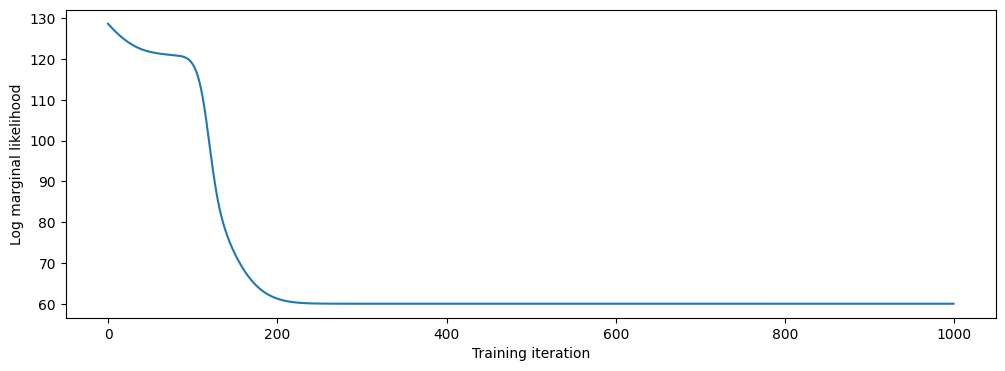

In [10]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [11]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

/tmp/ipykernel_241/2981963039.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


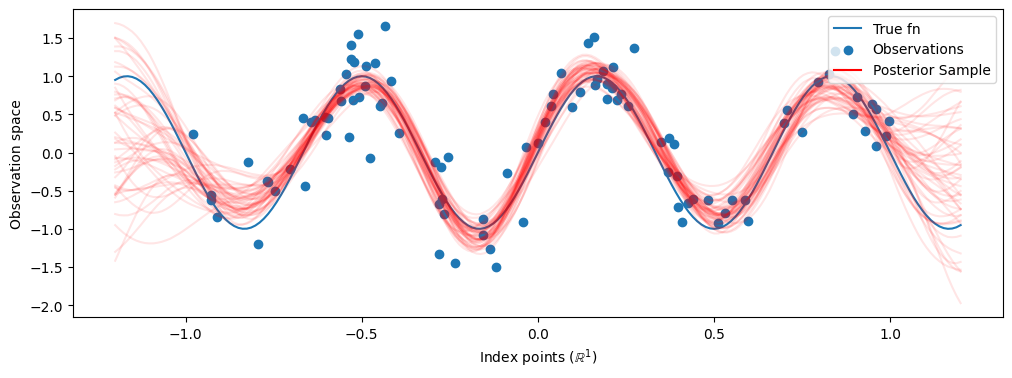

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()